# Import Packages

In [1]:
# declare imports
import argparse
from datetime import datetime
from pathlib import Path
import os
import sys
import dask.dataframe as dd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

path_to_functions = os.path.abspath("../src")

# Add this folder to the system path
sys.path.append(path_to_functions)

from pearl.post_processing.bmi import (
    add_summary,
    calc_overall_risk,
    calc_percentage,
    calc_percentage_and_add_summary,
    calc_risk_by_group,
    clean_control,
    create_summary_table,
    group_order,
    group_order_with_sub_total,
    group_title_dict,
    palette,
    rearrange_group_order,
    round_thousand,
    calc_dm_prop,
    add_sub_total,
    calc_overall_bmi_risk,
)

start_time = datetime.now()
df_summary_dict = {}

# Define the argument parser

baseline_dir = Path('../out/S0_10/combined')
variable_dir = Path('../out/S3_10/combined')
out_dir = Path('../results')

start_year = 2013
end_year = 2017

font_size = 9

C:\Users\jackz\.conda\envs\PEARL\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


# Figure 3

In [2]:
##############################################################################################################################
num_samples = 2000

# we will look at the "bmi_int_dm_prev.h5" for S1
bmi_int_dm_prev_s1 = dd.read_parquet(variable_dir / "dm_final_output.parquet").reset_index()

bmi_int_dm_prev_s1 = bmi_int_dm_prev_s1.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# Add Overall
all_but_group = list(bmi_int_dm_prev_s1.columns[1:])
bmi_int_dm_prev_s1_overall = bmi_int_dm_prev_s1.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_s1_overall["group"] = "overall"
bmi_int_dm_prev_s1 = dd.concat(
    [bmi_int_dm_prev_s1, bmi_int_dm_prev_s1_overall], ignore_index=True
)

# clean to control specifications
control_bmi_int_dm_prev_s1 = clean_control(bmi_int_dm_prev_s1, only_eligible=True, only_received=True)

# filter for only people eligible for intervention
bmi_int_s1_eligible_risk = calc_risk_by_group(control_bmi_int_dm_prev_s1, 7)

s1_sample = (
    bmi_int_s1_eligible_risk.groupby("group")
    .apply(lambda x: x.sample(num_samples, replace=True))
    .reset_index(drop=True)
    .compute()
)

del bmi_int_dm_prev_s1, bmi_int_s1_eligible_risk

# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(baseline_dir / "dm_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

bmi_int_eligible_risk = calc_risk_by_group(control_bmi_int_dm_prev, 7)

s0_sample = (
    bmi_int_eligible_risk.groupby("group")
    .apply(lambda x: x.sample(num_samples, replace=True))
    .reset_index(drop=True)
    .compute()
)

del bmi_int_dm_prev, bmi_int_eligible_risk

s0_sample = s0_sample.sort_values(by="group").reset_index(drop=True)
s1_sample = s1_sample.sort_values(by="group").reset_index(drop=True)

# absolute difference
abs_sample_diff = s1_sample[["dm_num", "risk"]] - s0_sample[["dm_num", "risk"]]
abs_sample_diff["group"] = s0_sample["group"]
abs_sample_diff["num"] = s0_sample["num"]

abs_sample_diff_plot = abs_sample_diff.copy()
abs_sample_diff_plot["group"] = abs_sample_diff_plot["group"].map(group_title_dict)
abs_sample_diff_plot["dm_num_prevented"] = abs_sample_diff_plot["dm_num"] * -1

# relative difference
rel_sample_diff = -(s1_sample[["risk"]] - s0_sample[["risk"]]) / s0_sample[["risk"]]
rel_sample_diff["group"] = s0_sample["group"]

rel_sample_diff_plot = rel_sample_diff.copy()
rel_sample_diff_plot["group"] = rel_sample_diff_plot["group"].map(group_title_dict)

C:\Users\jackz\AppData\Local\Temp\ipykernel_46352\338274080.py:37: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  .apply(lambda x: x.sample(num_samples, replace=True))
C:\Users\jackz\AppData\Local\Temp\ipykernel_46352\338274080.py:75: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  .apply(lambda x: x.sample(num_samples, replace=True))


## Record Risk for S0 and S1

In [ ]:
# Calculate and store S0
S0_risk_df = bmi_int_eligible_risk
S0_risk_df['group'] = S0_risk_df['group'].map(group_title_dict)

df = (
    S0_risk_df.groupby("group")[["risk"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]", axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "control_arm_risk.csv")

# Calculate and store S1
S1_risk_df = bmi_int_s1_eligible_risk
S1_risk_df['group'] = S1_risk_df['group'].map(group_title_dict)

df = (
    S0_risk_df.groupby("group")[["risk"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]", axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "control_arm_risk.csv")

## Fig 3A

C:\Users\jackz\AppData\Local\Temp\ipykernel_46352\941929807.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_info["risk"] = -overall_info["risk"]


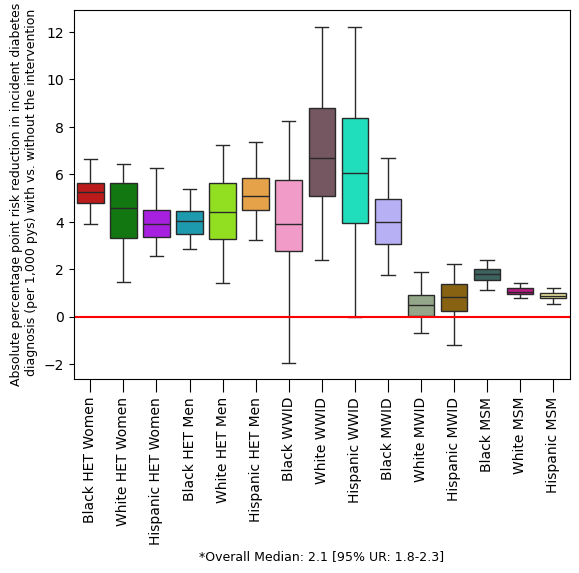

<Figure size 640x480 with 0 Axes>

In [18]:
#######################################################################################################
# Fig 3A
# absolute difference
abs_sample_diff = s1_sample[["dm_num", "risk"]] - s0_sample[["dm_num", "risk"]]
abs_sample_diff["group"] = s0_sample["group"]
abs_sample_diff["num"] = s0_sample["num"]

abs_sample_diff_plot = abs_sample_diff.copy()
abs_sample_diff_plot["group"] = abs_sample_diff_plot["group"].map(group_title_dict)

diff_ax = sns.boxplot(
    x=abs_sample_diff_plot["group"],
    y=-abs_sample_diff_plot["risk"],
    color="seagreen",
    whis = (2.5,97.5),
    showfliers=False,
    palette=palette,
    hue=abs_sample_diff_plot["group"],
    order=group_order[:-1],
    hue_order=group_order,
)

diff_ax.tick_params(axis="x", rotation=90, size = font_size)

overall_info = abs_sample_diff_plot[abs_sample_diff_plot['group'] == 'Overall']
overall_info["risk"] = -overall_info["risk"]
df = (
    overall_info.groupby("group")[["risk"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
overall_info_text = f'*Overall Median: {df[0.5][0]:.1f} [95% UR: {df[0.025][0]:.1f}-{df[0.975][0]:.1f}]'
########################################################

diff_ax.set_xlabel(overall_info_text, fontsize = font_size)
diff_ax.set_ylabel(
    "Absolute percentage point risk reduction in incident diabetes\n diagnosis (per 1,000 pys) with vs. without the intervention",
    fontsize=font_size,
)

diff_ax.axhline(y=0, color="r", linestyle="-")

diff_fig = diff_ax.get_figure()
diff_fig.savefig(out_dir / "fig3a.png", bbox_inches="tight")
plt.show()
plt.clf()

abs_sample_diff_plot["risk"] = -abs_sample_diff_plot["risk"]
df = (
    abs_sample_diff_plot.groupby("group")[["risk"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]", axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "figure3a_table.csv")

## Fig 3B

C:\Users\jackz\AppData\Local\Temp\ipykernel_46352\3869444004.py:9: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  rel_ax = sns.boxplot(
C:\Users\jackz\AppData\Local\Temp\ipykernel_46352\3869444004.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_info["risk"] = overall_info["risk"]*100


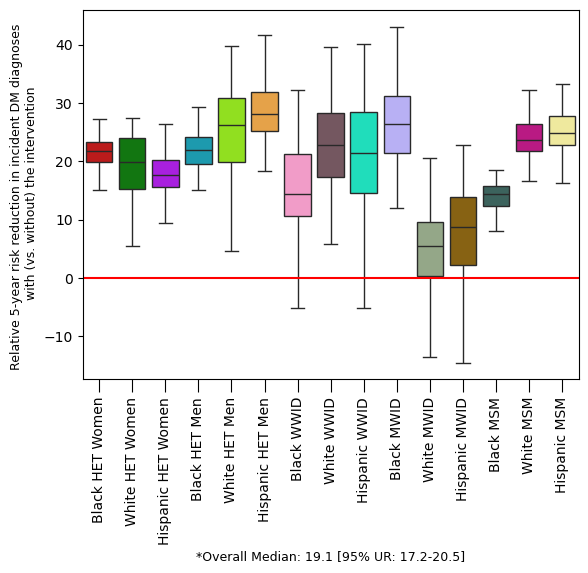

<Figure size 640x480 with 0 Axes>

In [25]:
# 3b
# relative difference
rel_sample_diff = -(s1_sample[["risk"]] - s0_sample[["risk"]]) / s0_sample[["risk"]]
rel_sample_diff["group"] = s0_sample["group"]

rel_sample_diff_plot = rel_sample_diff.copy()
rel_sample_diff_plot["group"] = rel_sample_diff_plot["group"].map(group_title_dict)

rel_ax = sns.boxplot(
    x=rel_sample_diff_plot["group"],
    y=rel_sample_diff_plot["risk"]*100,
    color="seagreen",
    showfliers=False,
    palette=palette,
    whis = (2.5,97.5),
    hue=rel_sample_diff_plot["group"],
    order=group_order[:-1],
    hue_order=group_order[:-1],
)

rel_ax.tick_params(axis="x", rotation=90,size = font_size)

overall_info = rel_sample_diff_plot[rel_sample_diff_plot['group'] == 'Overall']
overall_info["risk"] = overall_info["risk"]*100
df = (
    overall_info.groupby("group")[["risk"]]
    .quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
overall_info_text = f'*Overall Median: {df[0.5][0]:.1f} [95% UR: {df[0.025][0]:.1f}-{df[0.975][0]:.1f}]'
########################################################

rel_ax.set_xlabel(overall_info_text, fontsize = font_size)
rel_ax.set_ylabel(
    "Relative 5-year risk reduction in incident DM diagnoses \n with (vs. without) the intervention",
    fontsize=font_size,
)
rel_ax.axhline(y=0, color="r", linestyle="-")
rel_fig = rel_ax.get_figure()
rel_fig.savefig(out_dir / "fig3b.png", bbox_inches="tight")
plt.show()
plt.clf()

df = (
    rel_sample_diff_plot.groupby("group")[["risk"]]
    .quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.05, 0.5, 0.95]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.3f} [{row[0.05]:.3f} - {row[0.95]:.3f}]", axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "figure3b_table.csv")

## Fig 3C

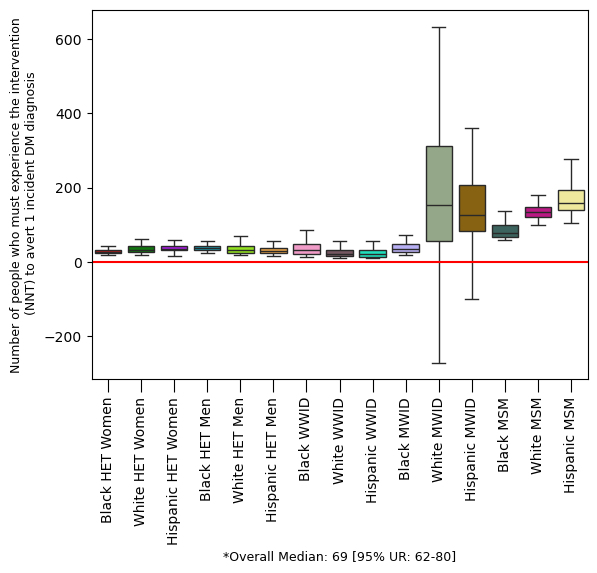

<Figure size 640x480 with 0 Axes>

In [26]:
# 3c
abs_sample_diff_plot["dm_per_1000"] = abs_sample_diff_plot["risk"] * (-1000)
abs_sample_diff_plot["NNT"] = -np.round(
    abs_sample_diff_plot["num"] / abs_sample_diff_plot["dm_num"], 0
)

dm_per_1000_ax = sns.boxplot(
    x=abs_sample_diff_plot["group"],
    y=abs_sample_diff_plot["NNT"],
    color="seagreen",
    showfliers=False,
    palette=palette,
    whis = (2.5,97.5),
    hue=abs_sample_diff_plot["group"],
    order=group_order[:-1],
    hue_order=group_order,
)

dm_per_1000_ax.tick_params(axis="x", rotation=90,size = font_size)

overall_info = abs_sample_diff_plot[abs_sample_diff_plot['group'] == 'Overall']
# overall_info["risk"] = overall_info["risk"]*100
df = (
    overall_info.groupby("group")[["NNT"]]
    .quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
overall_info_text = f'*Overall Median: {df[0.5][0]:.0f} [95% UR: {df[0.025][0]:.0f}-{df[0.975][0]:.0f}]'
########################################################

dm_per_1000_ax.set_xlabel(overall_info_text, fontsize = font_size)
dm_per_1000_ax.set_ylabel(
    "Number of people who must experience the intervention\n (NNT) to avert 1 incident DM diagnosis",
    fontsize=font_size,
)
dm_per_1000_ax.axhline(y=0, color="r", linestyle="-")
dm_per_1000_fig = dm_per_1000_ax.get_figure()
dm_per_1000_fig.savefig(out_dir / "fig3c.png", bbox_inches="tight")
plt.show()
plt.clf()

df = (
    abs_sample_diff_plot.groupby("group")[["NNT"]]
    .quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.05, 0.5, 0.95]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.0f} [{row[0.05]:.0f} - {row[0.95]:.0f}]", axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "figure3c_table.csv")

## Fig 3D

In [7]:
# 3d
abs_sample_diff_plot["dm_num_prevented"] = abs_sample_diff_plot["dm_num"] * -1
dm_prevented_ax = sns.boxplot(
    x=abs_sample_diff_plot["group"],
    y=abs_sample_diff_plot["dm_num_prevented"],
    color="seagreen",
    showfliers=False,
    palette=palette,
    whis = (2.5,97.5),
    hue=abs_sample_diff_plot["group"],
    order=group_order[:-1],
    hue_order=group_order,
)

dm_prevented_ax.tick_params(axis="x", rotation=90, size = font_size)

overall_info = abs_sample_diff_plot[abs_sample_diff_plot['group'] == 'Overall']
df = (
    overall_info.groupby("group")[["dm_num_prevented"]]
    .quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
overall_info_text = f'*Overall Median: {df[0.5][0]:,.0f} [95% UR: {df[0.025][0]:,.0f}-{df[0.975][0]:,.0f}]'
########################################################

dm_prevented_ax.set_xlabel(overall_info_text,fontsize = font_size)
dm_prevented_ax.set_ylabel(
    "Number of incident DM diagnoses averted\n (per 1000 people) with (vs. without) the intervention",
    fontsize=font_size,
)
dm_prevented_ax.axhline(y=0, color="r", linestyle="-")
dm_prevented_fig = dm_prevented_ax.get_figure()
dm_prevented_fig.savefig(out_dir / "fig3d.png", bbox_inches="tight")
plt.show()
plt.clf()

df = (
    abs_sample_diff_plot.groupby("group")[["dm_num_prevented"]]
    .quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.05, 0.5, 0.95]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.0f} [{row[0.05]:.0f} - {row[0.95]:.0f}]", axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "figure3d_table.csv")

NameError: name 'abs_sample_diff_plot' is not defined

# Figure 2

In [28]:
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(baseline_dir / "dm_final_output.parquet").reset_index()

# Now we will work on the remaining percentage columns
bmi_int_cascade = dd.read_parquet(baseline_dir / "bmi_int_cascade.parquet").reset_index()

# filter for only starting h1yy after 2013 and before 2017
control_bmi_int_cascade = bmi_int_cascade.loc[
    (bmi_int_cascade["h1yy"] >= start_year) & (bmi_int_cascade["h1yy"] <= 2017)
].compute()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

# sum across replications, group, and years_after_h1yy
control_bmi_int_dm_prev_agg = (
    control_bmi_int_dm_prev.groupby(
        ["group", "years_after_h1yy", "replication", "time_exposure_to_risk"]
    )["n"]
    .sum()
    .reset_index()
    .compute()
)

df = control_bmi_int_dm_prev_agg.groupby(['group', 'replication'])[['n']].sum().reset_index()
df['group'] = df['group'].map(group_title_dict)
df = df.groupby('group')[['n']].apply(lambda x: x.quantile([0.025,0.5,0.975])).unstack().reset_index()
df.columns = ['group',0.025, 0.5, 0.975]
df['formatted'] = df.apply(
    lambda row: '{:.0f} [{:.0f} - {:.0f}]'.format(round(row[0.50], -2), round(row[0.025], -2), round(row[0.975], -2)), axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir/'number_receiving_intervention_table.csv')
df_summary_dict['group'] = df['group']
df_summary_dict['Control|Number Receiving Intervention'] = df['formatted']

# Figure 2A
dm_risk_table = calc_overall_risk(control_bmi_int_dm_prev).compute()

## Fig 2A

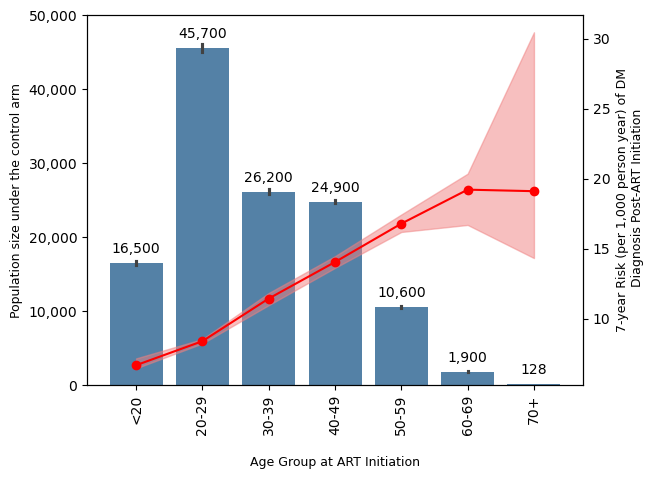

<Figure size 640x480 with 0 Axes>

In [36]:
# Figure 2A
# Graph Overall DM Probability and Population across ART initiation Groups
pop_ax = sns.barplot(
    x=dm_risk_table["init_age_group"],
    y=dm_risk_table["num"],
    estimator="median",
    color="steelblue",
    errorbar=("pi", 95),
)

pop_ax.tick_params(axis="x", rotation=90)

rounded_vals = [f'{round_thousand(x):,.0f}' for x in pop_ax.containers[0].datavalues]

pop_ax.bar_label(pop_ax.containers[0], labels=rounded_vals, padding=5)

pop_ax.set_ylabel("Population size under the control arm", fontsize = font_size)
pop_ax.set_xlabel("Age Group at ART Initiation", fontsize = font_size, labelpad = 15)
pop_ax.set_xticks(range(0, 7))
pop_ax.set_xticklabels(["<20", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"])
pop_ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
pop_ax.set_ylim(0,50000)

ax2 = pop_ax.twinx()
percentiles = (
    dm_risk_table.groupby("init_age_group")["risk"].quantile([0.025, 0.5, 0.975]).unstack()
)
ax2.plot(
    percentiles.index,
    percentiles.loc[:, 0.50],
    marker="o",
    linestyle="-",
    color="r",
    label="Median Risk",
)
ax2.fill_between(
    percentiles.index,
    percentiles.loc[:, 0.025],
    percentiles.loc[:, 0.975],
    color="lightcoral",
    alpha=0.5,
    label="95% CI",
)
ax2.set_ylabel("7-year Risk (per 1,000 person year) of DM\n Diagnosis Post-ART Initiation", fontsize = font_size)

pop_fig = pop_ax.get_figure()
pop_fig.savefig(out_dir / "fig2a.png", bbox_inches="tight")
# clear the plot
plt.show()
plt.clf()

df = dm_risk_table.groupby(['init_age_group'])[['num', 'risk']].quantile([0.025,0.5,0.975]).unstack()
final_df = pd.DataFrame()
for col in ['num', 'risk']:
    col_df = df[col].reset_index()
    if col == 'risk':
        final_df[col] = col_df.apply(lambda row: '{:.1f} [{:.1f} - {:.1f}]'.format(row[0.5], row[0.025], row[0.975]), axis=1)
    else:
        final_df[col] = col_df.apply(lambda row: '{:.0f} [{:.0f} - {:.0f}]'.format(round(row[0.5],-2), round(row[0.025],-2), round(row[0.975],-2)), axis=1)

final_df.to_csv(out_dir/'figure2a_table.csv', index = False)

## Fig 2B

In [44]:
## Fig2B
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(baseline_dir / "bmi_cat_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_bmi_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

dm_risk_table = calc_overall_bmi_risk(control_bmi_int_dm_prev).compute()

pre_art_bmi_bins = [0, 18.5, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, float("inf")]
# Create a label map
bmi_group_map = {i: f"[{pre_art_bmi_bins[i]}-{pre_art_bmi_bins[i+1]})" for i in range(len(pre_art_bmi_bins) - 1)}
bmi_group_map[12] = '>= 30'
group_order = list(bmi_group_map.values())

dm_risk_table["init_bmi_group"] = dm_risk_table["init_bmi_group"].map(bmi_group_map)

dm_risk_table

,init_bmi_group,replication,dm_num,person-time-contributed,num,risk
0,[18.5-20),0,432,51856.0,7408,8.330762
1,[18.5-20),1,428,51660.0,7380,8.284940
2,[18.5-20),2,379,50876.0,7268,7.449485
3,[18.5-20),3,421,52080.0,7440,8.083717
4,[18.5-20),4,422,51618.0,7374,8.175443
...,...,...,...,...,...,...
105,[29-30),5,1028,60424.0,8632,17.013107
106,[29-30),6,968,58793.0,8399,16.464545
107,[29-30),7,1060,61390.0,8770,17.266656
108,[29-30),8,1067,60746.0,8678,17.564943


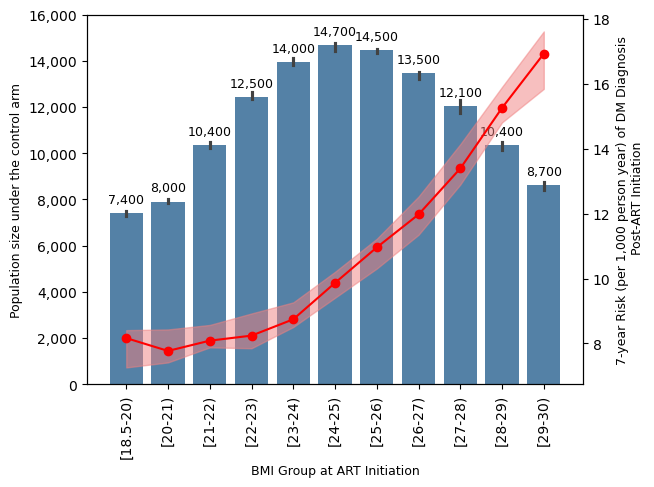

<Figure size 640x480 with 0 Axes>

In [50]:
# Graph Overall DM Probability and Population across BMI initiation Groups
pop_ax = sns.barplot(
    x=dm_risk_table["init_bmi_group"],
    y=dm_risk_table["num"],
    estimator="median",
    color="steelblue",
    errorbar=("pi", 95),
    order = group_order
)

pop_ax.tick_params(axis="x", rotation=90)

rounded_vals = [f'{round_thousand(x):,.0f}' for x in pop_ax.containers[0].datavalues]

pop_ax.bar_label(pop_ax.containers[0], labels=rounded_vals, padding=5, fontsize = font_size)

pop_ax.set_ylabel("Population size under the control arm", fontsize = font_size)
pop_ax.set_xlabel("BMI Group at ART Initiation", fontsize = font_size)
pop_ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
pop_ax.set_ylim(0,16000)

ax2 = pop_ax.twinx()
percentiles = (
    dm_risk_table.groupby("init_bmi_group")["risk"].quantile([0.025, 0.5, 0.975]).unstack()
)
ax2.plot(
    percentiles.index,
    percentiles.loc[:, 0.50],
    marker="o",
    linestyle="-",
    color="r",
    label="Median Risk",
)
ax2.fill_between(
    percentiles.index,
    percentiles.loc[:, 0.025],
    percentiles.loc[:, 0.975],
    color="lightcoral",
    alpha=0.5,
    label="95% CI",
)

ax2.set_ylabel("7-year Risk (per 1,000 person year) of DM Diagnosis\n Post-ART Initiation", fontsize = font_size)

pop_fig = pop_ax.get_figure()
pop_fig.savefig(out_dir / "fig2b.png", bbox_inches="tight")
# clear the plot
plt.show()
plt.clf()

df = dm_risk_table.groupby(['init_bmi_group'])[['num', 'risk']].quantile([0.025,0.5,0.975]).unstack()
final_df = pd.DataFrame()
for col in ['num', 'risk']:
    col_df = df[col].reset_index()
    if col == 'risk':
        final_df[col] = col_df.apply(lambda row: '{:.1f} [{:.1f} - {:.1f}]'.format(row[0.5], row[0.025], row[0.975]), axis=1)
    else:
        final_df[col] = col_df.apply(lambda row: '{:.0f} [{:.0f} - {:.0f}]'.format(round(row[0.5],-2), round(row[0.025],-2), round(row[0.975],-2)), axis=1)

final_df.to_csv(out_dir/'figure2b_table.csv', index = False)

## Fig 2C

In [2]:
########################################################################################################
# 2c
bmi_int_dm_prev = dd.read_parquet(baseline_dir /'dm_final_output.parquet').reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall['group'] = 'overall'
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype({'group':'str', 'replication':'int16', 'bmiInt_scenario':np.int8, 'h1yy': np.int16, 'bmiInt_impacted':bool, 'dm': bool, 't_dm': np.int16, 'n': np.int16})

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True).compute()

group_dm_risk_table = calc_risk_by_group(control_bmi_int_dm_prev, 7).compute()

group_dm_risk_table["group"] = group_dm_risk_table["group"].map(group_title_dict)

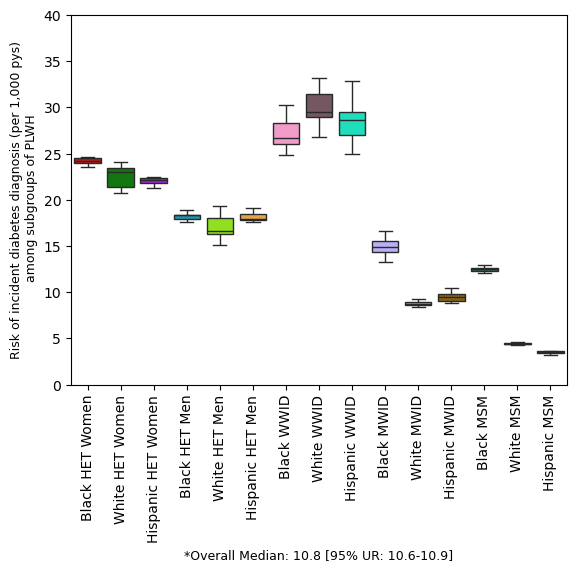

<Figure size 640x480 with 0 Axes>

In [4]:
group_risk_ax = sns.boxplot(
    x=group_dm_risk_table["group"],
    y=group_dm_risk_table["risk"],
    color="seagreen",
    showfliers=False,
    palette=palette,
    whis = (2.5,97.5),
    hue=group_dm_risk_table["group"],
    order=group_order[:-1],
    hue_order=group_order,
)

group_risk_ax.tick_params(axis="x", rotation=90)

overall_info = group_dm_risk_table[group_dm_risk_table['group'] == 'Overall']
df = (
    overall_info.groupby("group")[["risk"]]
    .quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
overall_info_text = f'*Overall Median: {df[0.5][0]:,.1f} [95% UR: {df[0.025][0]:,.1f}-{df[0.975][0]:,.1f}]'
########################################################

group_risk_ax.set_xlabel(overall_info_text,fontsize = font_size, labelpad= 5)
group_risk_ax.set_ylabel("Risk of incident diabetes diagnosis (per 1,000 pys)\n among subgroups of PLWH", fontsize = font_size)
group_risk_ax.set_ylim(0, 40)
group_risk_fig = group_risk_ax.get_figure()
group_risk_fig.savefig(out_dir / "fig2c.png", bbox_inches="tight")
plt.show()
plt.clf()

# table 2c
df = (
    group_dm_risk_table.groupby("group")[["risk"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]",
    axis=1,
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "figure2c_table.csv")
df_summary_dict['Control|7-year Risk of DM Diagnosis Post-ART Initiation'] = df['formatted']

## Fig 2D

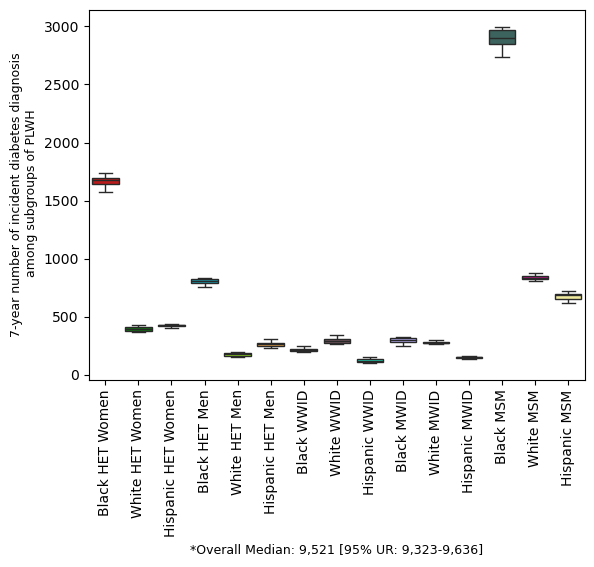

Figure 2 Finished.


<Figure size 640x480 with 0 Axes>

In [6]:
# 2D
group_risk_ax = sns.boxplot(
    x=group_dm_risk_table["group"],
    y=group_dm_risk_table["dm_num"],
    color="seagreen",
    showfliers=False,
    palette=palette,
    whis = (2.5,97.5),
    hue=group_dm_risk_table["group"],
    order=group_order[:-1],
    hue_order=group_order,
)

group_risk_ax.tick_params(axis="x", rotation=90)

########################################################
# last_group = group_order[-1]
# secondary_ax = diff_ax.twinx()  # Create secondary y-axis

# # Plot the last group's data on the secondary axis
# sns.boxplot(
#     x=abs_sample_diff_plot[abs_sample_diff_plot["group"] == last_group]["group"],
#     y=-abs_sample_diff_plot[abs_sample_diff_plot["group"] == last_group]["risk"],
#     ax=secondary_ax,
#     color="skyblue",
#     showfliers=False,
#     width=0.5,
#     order=group_order,
# )

# # Make the secondary y-axis labels visible
# secondary_ax.set_ylabel("* Overall", fontsize=8.5)

# # Set y-labels to same font size for clarity
# secondary_ax.tick_params(axis='y', labelsize=8.5)
# diff_ax.tick_params(axis='y', labelsize=8.5)

# diff_ax.axvline(x=len(group_order)-1.5, color="red", linestyle="--")

overall_info = group_dm_risk_table[group_dm_risk_table['group'] == 'Overall']
df = (
    overall_info.groupby("group")[["dm_num"]]
    .quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
overall_info_text = f'*Overall Median: {df[0.5][0]:,.0f} [95% UR: {df[0.025][0]:,.0f}-{df[0.975][0]:,.0f}]'
########################################################

group_risk_ax.set_xlabel(overall_info_text, fontsize = font_size,labelpad = 5)
group_risk_ax.set_ylabel("7-year number of incident diabetes diagnosis\n among subgroups of PLWH", fontsize = font_size)
group_risk_fig = group_risk_ax.get_figure()
group_risk_fig.savefig(out_dir / "fig2d.png", bbox_inches="tight")
plt.show()
plt.clf()

df = (
    group_dm_risk_table.groupby("group")[["dm_num"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]", axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "figure2d_table.csv")
df_summary_dict['Control|7-year Number of DM Diagnosis Post-ART Initiation'] = df['formatted']

pd.DataFrame(df_summary_dict).to_csv(out_dir/'df_summary.csv', index = False)

print("Figure 2 Finished.")

## Test

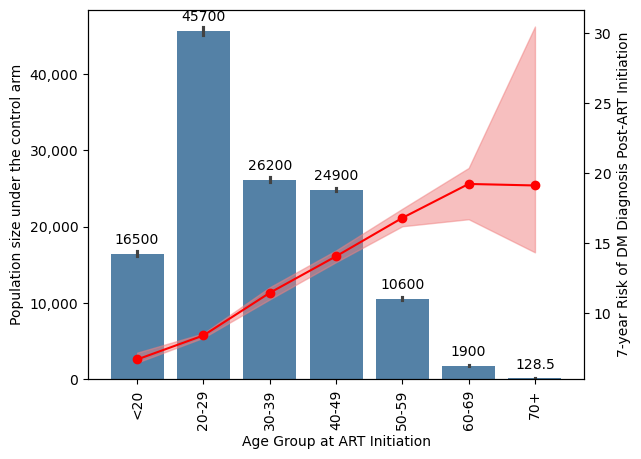

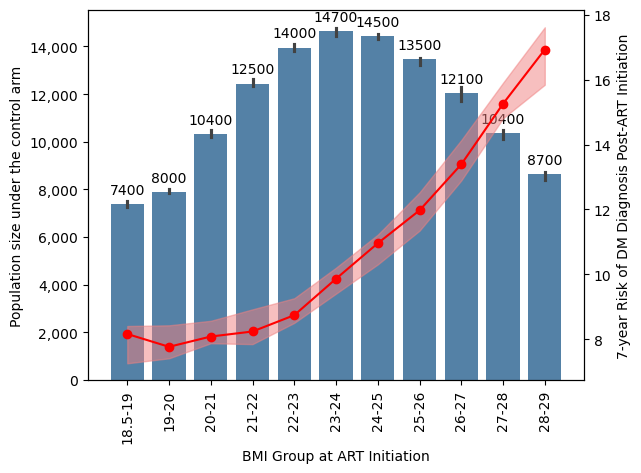

<Figure size 640x480 with 0 Axes>

In [2]:
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(baseline_dir / "dm_final_output.parquet").reset_index()

# Now we will work on the remaining percentage columns
bmi_int_cascade = dd.read_parquet(baseline_dir / "bmi_int_cascade.parquet").reset_index()

# filter for only starting h1yy after 2013 and before 2017
control_bmi_int_cascade = bmi_int_cascade.loc[
    (bmi_int_cascade["h1yy"] >= start_year) & (bmi_int_cascade["h1yy"] <= 2017)
].compute()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

# sum across replications, group, and years_after_h1yy
control_bmi_int_dm_prev_agg = (
    control_bmi_int_dm_prev.groupby(
        ["group", "years_after_h1yy", "replication", "time_exposure_to_risk"]
    )["n"]
    .sum()
    .reset_index()
    .compute()
)

df = control_bmi_int_dm_prev_agg.groupby(['group', 'replication'])[['n']].sum().reset_index()
df['group'] = df['group'].map(group_title_dict)
df = df.groupby('group')[['n']].apply(lambda x: x.quantile([0.025,0.5,0.975])).unstack().reset_index()
df.columns = ['group',0.025, 0.5, 0.975]
df['formatted'] = df.apply(
    lambda row: '{:.0f} [{:.0f} - {:.0f}]'.format(round(row[0.50], -2), round(row[0.025], -2), round(row[0.975], -2)), axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir/'number_receiving_intervention_table.csv')
df_summary_dict['group'] = df['group']
df_summary_dict['Control|Number Receiving Intervention'] = df['formatted']

# Figure 2A
dm_risk_table = calc_overall_risk(control_bmi_int_dm_prev).compute()

# Graph Overall DM Probability and Population across ART initiation Groups
pop_ax = sns.barplot(
    x=dm_risk_table["init_age_group"],
    y=dm_risk_table["num"],
    estimator="median",
    color="steelblue",
    errorbar=("pi", 95),
)

pop_ax.tick_params(axis="x", rotation=90)

rounded_vals = [round_thousand(x) for x in pop_ax.containers[0].datavalues]

pop_ax.bar_label(pop_ax.containers[0], labels=rounded_vals, padding=5)

pop_ax.set_ylabel("Population size under the control arm")
pop_ax.set_xlabel("Age Group at ART Initiation")
pop_ax.set_xticks(range(0, 7))
pop_ax.set_xticklabels(["<20", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"])
pop_ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))

ax2 = pop_ax.twinx()
percentiles = (
    dm_risk_table.groupby("init_age_group")["risk"].quantile([0.025, 0.5, 0.975]).unstack()
)
ax2.plot(
    percentiles.index,
    percentiles.loc[:, 0.50],
    marker="o",
    linestyle="-",
    color="r",
    label="Median Risk",
)
ax2.fill_between(
    percentiles.index,
    percentiles.loc[:, 0.025],
    percentiles.loc[:, 0.975],
    color="lightcoral",
    alpha=0.5,
    label="95% CI",
)
ax2.set_ylabel("7-year Risk of DM Diagnosis Post-ART Initiation")

pop_fig = pop_ax.get_figure()
pop_fig.savefig(out_dir / "fig2a.png", bbox_inches="tight")
# clear the plot
plt.show()
plt.clf()

df = dm_risk_table.groupby(['init_age_group'])[['num', 'risk']].quantile([0.025,0.5,0.975]).unstack()
final_df = pd.DataFrame()
for col in ['num', 'risk']:
    col_df = df[col].reset_index()
    if col == 'risk':
        final_df[col] = col_df.apply(lambda row: '{:.1f} [{:.1f} - {:.1f}]'.format(row[0.5], row[0.025], row[0.975]), axis=1)
    else:
        final_df[col] = col_df.apply(lambda row: '{:.0f} [{:.0f} - {:.0f}]'.format(round(row[0.5],-2), round(row[0.025],-2), round(row[0.975],-2)), axis=1)

final_df.to_csv(out_dir/'figure2a_table.csv', index = False)

## Fig2B
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(baseline_dir / "bmi_cat_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_bmi_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

dm_risk_table = calc_overall_bmi_risk(control_bmi_int_dm_prev).compute()

pre_art_bmi_bins = [0, 18.5, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, float("inf")]
# Create a label map
bmi_group_map = {i: f"{pre_art_bmi_bins[i]}-{pre_art_bmi_bins[i+1]}" for i in range(len(pre_art_bmi_bins) - 1)}
bmi_group_map[13] = '> 30'
group_order = list(bmi_group_map.values())

dm_risk_table["init_bmi_group"] = dm_risk_table["init_bmi_group"].map(bmi_group_map)

# Graph Overall DM Probability and Population across BMI initiation Groups
pop_ax = sns.barplot(
    x=dm_risk_table["init_bmi_group"],
    y=dm_risk_table["num"],
    estimator="median",
    color="steelblue",
    errorbar=("pi", 95),
    order = group_order
)

pop_ax.tick_params(axis="x", rotation=90)

rounded_vals = [round_thousand(x) for x in pop_ax.containers[0].datavalues]

pop_ax.bar_label(pop_ax.containers[0], labels=rounded_vals, padding=5)

pop_ax.set_ylabel("Population size under the control arm")
pop_ax.set_xlabel("BMI Group at ART Initiation")
pop_ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))

ax2 = pop_ax.twinx()
percentiles = (
    dm_risk_table.groupby("init_bmi_group")["risk"].quantile([0.025, 0.5, 0.975]).unstack()
)
ax2.plot(
    percentiles.index,
    percentiles.loc[:, 0.50],
    marker="o",
    linestyle="-",
    color="r",
    label="Median Risk",
)
ax2.fill_between(
    percentiles.index,
    percentiles.loc[:, 0.025],
    percentiles.loc[:, 0.975],
    color="lightcoral",
    alpha=0.5,
    label="95% CI",
)

ax2.set_ylabel("7-year Risk of DM Diagnosis Post-ART Initiation")

pop_fig = pop_ax.get_figure()
pop_fig.savefig(out_dir / "fig2b.png", bbox_inches="tight")
# clear the plot
plt.show()
plt.clf()

df = dm_risk_table.groupby(['init_bmi_group'])[['num', 'risk']].quantile([0.025,0.5,0.975]).unstack()
final_df = pd.DataFrame()
for col in ['num', 'risk']:
    col_df = df[col].reset_index()
    if col == 'risk':
        final_df[col] = col_df.apply(lambda row: '{:.1f} [{:.1f} - {:.1f}]'.format(row[0.5], row[0.025], row[0.975]), axis=1)
    else:
        final_df[col] = col_df.apply(lambda row: '{:.0f} [{:.0f} - {:.0f}]'.format(round(row[0.5],-2), round(row[0.025],-2), round(row[0.975],-2)), axis=1)

final_df.to_csv(out_dir/'figure2b_table.csv', index = False)

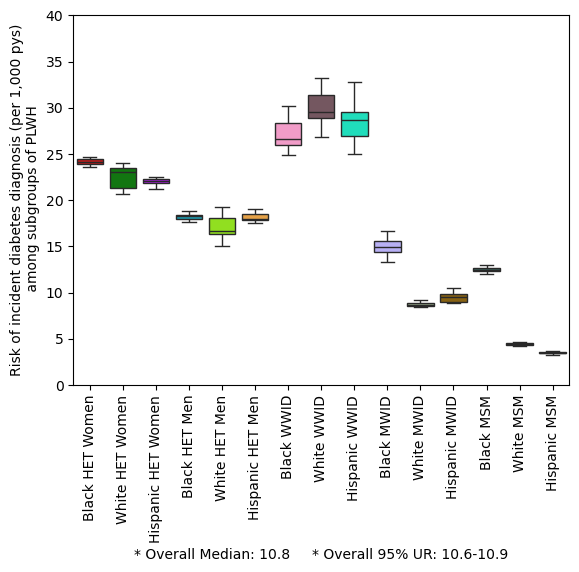

<Figure size 640x480 with 0 Axes>

In [4]:
########################################################################################################
# 2c
bmi_int_dm_prev = dd.read_parquet(baseline_dir /'dm_final_output.parquet').reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall['group'] = 'overall'
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype({'group':'str', 'replication':'int16', 'bmiInt_scenario':np.int8, 'h1yy': np.int16, 'bmiInt_impacted':bool, 'dm': bool, 't_dm': np.int16, 'n': np.int16})

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True).compute()

group_dm_risk_table = calc_risk_by_group(control_bmi_int_dm_prev, 7).compute()

group_dm_risk_table["group"] = group_dm_risk_table["group"].map(group_title_dict)

group_risk_ax = sns.boxplot(
    x=group_dm_risk_table["group"],
    y=group_dm_risk_table["risk"],
    color="seagreen",
    showfliers=False,
    palette=palette,
    hue=group_dm_risk_table["group"],
    order=group_order[:-1],
    hue_order=group_order,
)

group_risk_ax.tick_params(axis="x", rotation=90)

########################################################
# last_group = group_order[-1]
# secondary_ax = diff_ax.twinx()  # Create secondary y-axis

# # Plot the last group's data on the secondary axis
# sns.boxplot(
#     x=abs_sample_diff_plot[abs_sample_diff_plot["group"] == last_group]["group"],
#     y=-abs_sample_diff_plot[abs_sample_diff_plot["group"] == last_group]["risk"],
#     ax=secondary_ax,
#     color="skyblue",
#     showfliers=False,
#     width=0.5,
#     order=group_order,
# )

# # Make the secondary y-axis labels visible
# secondary_ax.set_ylabel("* Overall", fontsize=8.5)

# # Set y-labels to same font size for clarity
# secondary_ax.tick_params(axis='y', labelsize=8.5)
# diff_ax.tick_params(axis='y', labelsize=8.5)

# diff_ax.axvline(x=len(group_order)-1.5, color="red", linestyle="--")

overall_info = group_dm_risk_table[group_dm_risk_table['group'] == 'Overall']
df = (
    overall_info.groupby("group")[["risk"]]
    .quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
overall_info_text = f'* Overall Median: {df[0.5][0]:.1f}     * Overall 95% UR: {df[0.025][0]:.1f}-{df[0.975][0]:.1f}'
########################################################

group_risk_ax.set_xlabel(overall_info_text)
group_risk_ax.set_ylabel("Risk of incident diabetes diagnosis (per 1,000 pys)\n among subgroups of PLWH")
group_risk_ax.set_ylim(0, 40)
group_risk_fig = group_risk_ax.get_figure()
group_risk_fig.savefig(out_dir / "fig2c.png", bbox_inches="tight")
plt.show()
plt.clf()

# table 2c
df = (
    group_dm_risk_table.groupby("group")[["risk"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]",
    axis=1,
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "figure2c_table.csv")
df_summary_dict['Control|7-year Risk of DM Diagnosis Post-ART Initiation'] = df['formatted']

In [4]:
group_dm_risk_table

,group,replication,dm_num,person-time-contributed,num,risk
0,Black HET Women,0,1694,68880,9840,24.593496
1,Black HET Women,1,1701,70553,10079,24.109535
2,Black HET Women,2,1738,71603,10229,24.272726
3,Black HET Women,3,1676,70042,10006,23.928500
4,Black HET Women,4,1679,68369,9767,24.557914
...,...,...,...,...,...,...
155,Overall,5,9512,879956,125708,10.809631
156,Overall,6,9271,877296,125328,10.567699
157,Overall,7,9497,884800,126400,10.733499
158,Overall,8,9611,884758,126394,10.862857


In [ ]:
# 2D
# group_dm_risk_table = calc_risk_by_group(control_bmi_int_dm_prev, 7).compute()

# group_dm_risk_table["group"] = group_dm_risk_table["group"].map(group_title_dict)

group_risk_ax = sns.boxplot(
    x=group_dm_risk_table["group"],
    y=group_dm_risk_table["dm_num"],
    color="seagreen",
    showfliers=False,
    palette=palette,
    hue=group_dm_risk_table["group"],
    order=group_order[:-1],
    hue_order=group_order,
)

group_risk_ax.tick_params(axis="x", rotation=90)

########################################################
# last_group = group_order[-1]
# secondary_ax = diff_ax.twinx()  # Create secondary y-axis

# # Plot the last group's data on the secondary axis
# sns.boxplot(
#     x=abs_sample_diff_plot[abs_sample_diff_plot["group"] == last_group]["group"],
#     y=-abs_sample_diff_plot[abs_sample_diff_plot["group"] == last_group]["risk"],
#     ax=secondary_ax,
#     color="skyblue",
#     showfliers=False,
#     width=0.5,
#     order=group_order,
# )

# # Make the secondary y-axis labels visible
# secondary_ax.set_ylabel("* Overall", fontsize=8.5)

# # Set y-labels to same font size for clarity
# secondary_ax.tick_params(axis='y', labelsize=8.5)
# diff_ax.tick_params(axis='y', labelsize=8.5)

# diff_ax.axvline(x=len(group_order)-1.5, color="red", linestyle="--")

overall_info = group_dm_risk_table[group_dm_risk_table['group'] == 'Overall']
df = (
    overall_info.groupby("group")[["dm_num"]]
    .quantile([0.05, 0.5, 0.95])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
overall_info_text = f'* Overall Median: {df[0.5][0]:.0f}     * Overall 95% UR: {df[0.025][0]:.0f}-{df[0.975][0]:.0f}'
########################################################

group_risk_ax.set_xlabel(overall_info_text)
group_risk_ax.set_ylabel("7-year number of incident diabetes diagnosis\n among subgroups of PLWH")
group_risk_fig = group_risk_ax.get_figure()
group_risk_fig.savefig(out_dir / "fig2d.png", bbox_inches="tight")
plt.show()
plt.clf()

df = (
    group_dm_risk_table.groupby("group")[["dm_num"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]", axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "figure2d_table.csv")
df_summary_dict['Control|7-year Number of DM Diagnosis Post-ART Initiation'] = df['formatted']

pd.DataFrame(df_summary_dict).to_csv(out_dir/'df_summary.csv', index = False)

print("Figure 2 Finished.")